<a href="https://colab.research.google.com/github/YongWanJin/KDTteam5_semiproject/blob/main/code/%EC%95%88%EC%A0%95%ED%99%94%EA%B0%80_%EC%95%84%EB%8B%8C_%ED%99%9C%EC%84%B1%ED%99%94%EB%B0%A9%EC%95%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 구글 드라이브에 접근
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#한글 글꼴 설치
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [3]:
# 필요한 모듈 불러오기
from glob import glob      
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import folium
from IPython.display import display 

================================================================================

In [4]:
### 원본 데이터 raw data 불러오기

# 1. 상권코드&추정매출액 (2017~2022Q1) 불러오기&병합
# 변수명 : sales
# 역할 : 매출증가율 계산에 사용될 데이터가 들어있음.

file_names = glob("/content/gdrive/MyDrive/datafile/추정매출(2017~2022Q1)/*.csv") 

sales = pd.DataFrame()    
for file_name in file_names : 
    temp = pd.read_csv(file_name, encoding='CP949')
    sales = pd.concat([sales, temp])               
del(temp)

sales.reset_index(inplace=True, drop=True)          


In [5]:
# 2. 상권코드&행정동코드&좌표값 불러오기
# 변수명 : location
# 역할 : 구 별로 구분, 지도시각화에 필요한 데이터가 들어있음.
location = pd.read_csv("/content/gdrive/MyDrive/datafile/상권영역_위도경도추가.csv")

# 3. 행정동코드&행정동이름 불러오기
# 변수명 : name
# 역할 : 구 별로 구분, 지도시각화에 필요한 데이터가 들어있음.
name = pd.read_csv("/content/gdrive/MyDrive/datafile/행정동코드-이름_매치파일.csv")

In [6]:
### sales 전처리 : sales 데이터에서 필요한 부분만 골라내기

# 분기 순서에 맞춰 필요한 연도(2019년 3분기 ~ 2022년 1분기) 추출
sales = sales[ sales['기준_년_코드'] >= 2019  ] # 연도 추출
sales.drop( sales[(sales['기준_년_코드']==2019)&(sales['기준_분기_코드']<=2)].index, inplace=True) # 필요없는 분기 제거

# 필요한 업종(식당업)만 추출
sales['서비스_업종_코드'] = sales['서비스_업종_코드'].str.replace(pat=r'[CS]',repl=r'', regex=True).astype('int')
sales = sales[ sales['서비스_업종_코드'] <= 100010]  

# 필요한 columns 골라내기
sales = sales[['기준_년_코드', '기준_분기_코드', '상권_코드', '분기당_매출_금액', '상권_구분_코드_명', '서비스_업종_코드_명']]

display(sales) # 결과

,기준_년_코드,기준_분기_코드,상권_코드,분기당_매출_금액,상권_구분_코드_명,서비스_업종_코드_명
0,2021,1,2110001,626851391,골목상권,한식음식점
1,2021,1,2110001,122957138,골목상권,분식전문점
2,2021,1,2110001,5093349,골목상권,호프-간이주점
3,2021,1,2110001,13507733,골목상권,커피-음료
12,2021,1,2110002,361894416,골목상권,한식음식점
...,...,...,...,...,...,...
825947,2022,1,2110002,346852071,골목상권,한식음식점
825956,2022,1,2110001,20931521,골목상권,커피-음료
825957,2022,1,2110001,5119924,골목상권,호프-간이주점
825958,2022,1,2110001,92420017,골목상권,분식전문점


In [7]:
### name의 상권코드와 location의 행정동코드 병합하기 (location에 병합)

# location 전처리 : 필요한 행만 골라내기
location = location[['상권_코드', '행정동_코드', '경도', '위도']]

# name 전처리 : location의 행정동코드와 자릿수를 같게 만들기
name['행정동코드'] = name['행정동코드']/100
name['행정동코드'] = name['행정동코드'].astype(int)

# name 전처리 : 필요한 열, 필요한 행만 골라내기
name = name[name['시도명']=='서울특별시']
name = name[['행정동코드', '시군구명', '읍면동명']]

# location과 name을 location에 join
location = pd.merge(location, name, left_on='행정동_코드', right_on='행정동코드')
location.drop('행정동_코드', axis='columns', inplace=True) # 중복되는 열 제거

display(location) # 결과

,상권_코드,경도,위도,행정동코드,시군구명,읍면동명
0,2110753,126.908844,37.448687,11545710,금천구,시흥제5동
1,2110748,126.904810,37.448765,11545710,금천구,시흥제5동
2,2110754,126.910150,37.452869,11545710,금천구,시흥제5동
3,2130238,126.910095,37.451617,11545710,금천구,시흥제5동
4,2110427,127.070978,37.634469,11350611,노원구,하계1동
...,...,...,...,...,...,...
3677,2130166,126.918620,37.594260,11380590,은평구,응암제2동
3678,2130113,127.094587,37.606387,11260690,중랑구,신내2동
3679,2130051,127.017283,37.562266,11140665,중구,동화동
3680,2130102,127.062547,37.604597,11230750,동대문구,이문제2동


In [8]:
### location과 sales 병합하기 (sales에 병합)
sales = pd.merge(sales, location, left_on = '상권_코드', right_on='상권_코드')
sales = sales[['기준_년_코드', '기준_분기_코드', '시군구명', '읍면동명', '분기당_매출_금액', '상권_구분_코드_명', '서비스_업종_코드_명', '경도', '위도']]

# 어디선가 꼬여버린 순서를 분기 순서에 맞게 재배치
temp1 = sales[sales['기준_년_코드']==2019].sort_values(by='기준_분기_코드')
for y in range(2020, 2023) :
    temp2 = sales[sales['기준_년_코드']==y].sort_values(by='기준_분기_코드')
    temp1 = pd.concat([temp1, temp2])
sales = temp1
del(temp1)
del(temp2)

### 연도와 분기를 구분해주는 라벨링 작업 : 추후 반복작업을 위해서
sales_time = sales[['기준_년_코드', '기준_분기_코드']].drop_duplicates()
sales_time['시점_구분_변수'] = [p for p in range(len(sales_time))]
sales = pd.merge(sales, sales_time)

In [9]:
display(sales) # 결과물

,기준_년_코드,기준_분기_코드,시군구명,읍면동명,분기당_매출_금액,상권_구분_코드_명,서비스_업종_코드_명,경도,위도,시점_구분_변수
0,2019,3,종로구,평창동,617366771,골목상권,한식음식점,126.956884,37.609345,0
1,2019,3,영등포구,양평제2동,1715934320,골목상권,한식음식점,126.892219,37.536260,0
2,2019,3,영등포구,양평제2동,1715934320,골목상권,한식음식점,126.892219,37.536260,0
3,2019,3,영등포구,양평제2동,1715934320,골목상권,한식음식점,126.892219,37.536260,0
4,2019,3,중구,명동,2170985300,발달상권,양식음식점,126.977667,37.567626,0
...,...,...,...,...,...,...,...,...,...,...
223759,2022,1,금천구,독산제2동,58629176,골목상권,패스트푸드점,126.901897,37.463747,10
223760,2022,1,금천구,독산제2동,19662439,골목상권,치킨전문점,126.901897,37.463747,10
223761,2022,1,금천구,독산제2동,160504059,골목상권,분식전문점,126.901897,37.463747,10
223762,2022,1,금천구,시흥제1동,199970430,골목상권,분식전문점,126.902834,37.447169,10


데이터 전처리 완료. 이제 이 salse 변수로부터 원하는 데이터를 뽑아내서 시각화를 하면 된다.

================================================================================

In [107]:
### 매출액 평균만으로 한번 따져보자 그럼.

# 구 별 매출 평균을 입력할 데이터프레임 mean_gu 생성
index = [gu for gu in sales['시군구명'].unique()]
columns = ["2019년3분기","2019년4분기", "2020년1분기", "2020년2분기", "2020년3분기", "2020년4분기",
           "2021년1분기", "2021년2분기", "2021년3분기", "2021년4분기", "2022년1분기"]
mean_gu = pd.DataFrame(index = index, columns = columns) 

# 구 단위로 매출 평균 계산 후 입력
for p in range( len(sales['시점_구분_변수'].unique()) ) :
    means = sales[ sales['시점_구분_변수']==p ].groupby('시군구명')['분기당_매출_금액'].mean()
    means = np.array(means) 
    means = np.round(means, -5).reshape(25,1)
    means = means.tolist()
    mean_gu.iloc[:,[p]] = means # 입력

# 구 전체 평균 입력
mean_all = []
for i in range(len(mean_gu.columns)) :
    mean_q = round(mean_gu.iloc[:,[i]].mean()[0], -5)
    mean_all.append(mean_q)
mean_gu.loc[len(mean_gu)] = mean_all
mean_gu.rename(index={25:'구전체평균'}, inplace=True)


display(mean_gu) # 결과

,2019년3분기,2019년4분기,2020년1분기,2020년2분기,2020년3분기,2020년4분기,2021년1분기,2021년2분기,2021년3분기,2021년4분기,2022년1분기
종로구,1344800000.0,1489700000.0,1213900000.0,1274100000.0,1238700000.0,1146400000.0,1051700000.0,1257500000.0,1071300000.0,1385000000.0,1176000000.0
영등포구,496000000.0,551500000.0,478800000.0,517100000.0,473700000.0,430200000.0,391100000.0,442300000.0,420800000.0,492700000.0,427400000.0
중구,300500000.0,326800000.0,280200000.0,317700000.0,285700000.0,245200000.0,212700000.0,261000000.0,245500000.0,275700000.0,232700000.0
강동구,436200000.0,462800000.0,390300000.0,409200000.0,389900000.0,351300000.0,324300000.0,370000000.0,337100000.0,386300000.0,340700000.0
금천구,464900000.0,481100000.0,412900000.0,434100000.0,398200000.0,349300000.0,308000000.0,352800000.0,327700000.0,397900000.0,345200000.0
송파구,523200000.0,620500000.0,486800000.0,507100000.0,467800000.0,426300000.0,380200000.0,465500000.0,416500000.0,501300000.0,434300000.0
강북구,499500000.0,545100000.0,461300000.0,491800000.0,463600000.0,433300000.0,405300000.0,459100000.0,392000000.0,471500000.0,400900000.0
구로구,542000000.0,585900000.0,505800000.0,552400000.0,526700000.0,496100000.0,459000000.0,536300000.0,478200000.0,576000000.0,494200000.0
성북구,564700000.0,634000000.0,538500000.0,581800000.0,533500000.0,480600000.0,425000000.0,511200000.0,476600000.0,534200000.0,468000000.0
동작구,307200000.0,325400000.0,292500000.0,321100000.0,292300000.0,266900000.0,241300000.0,278000000.0,269400000.0,295100000.0,259200000.0


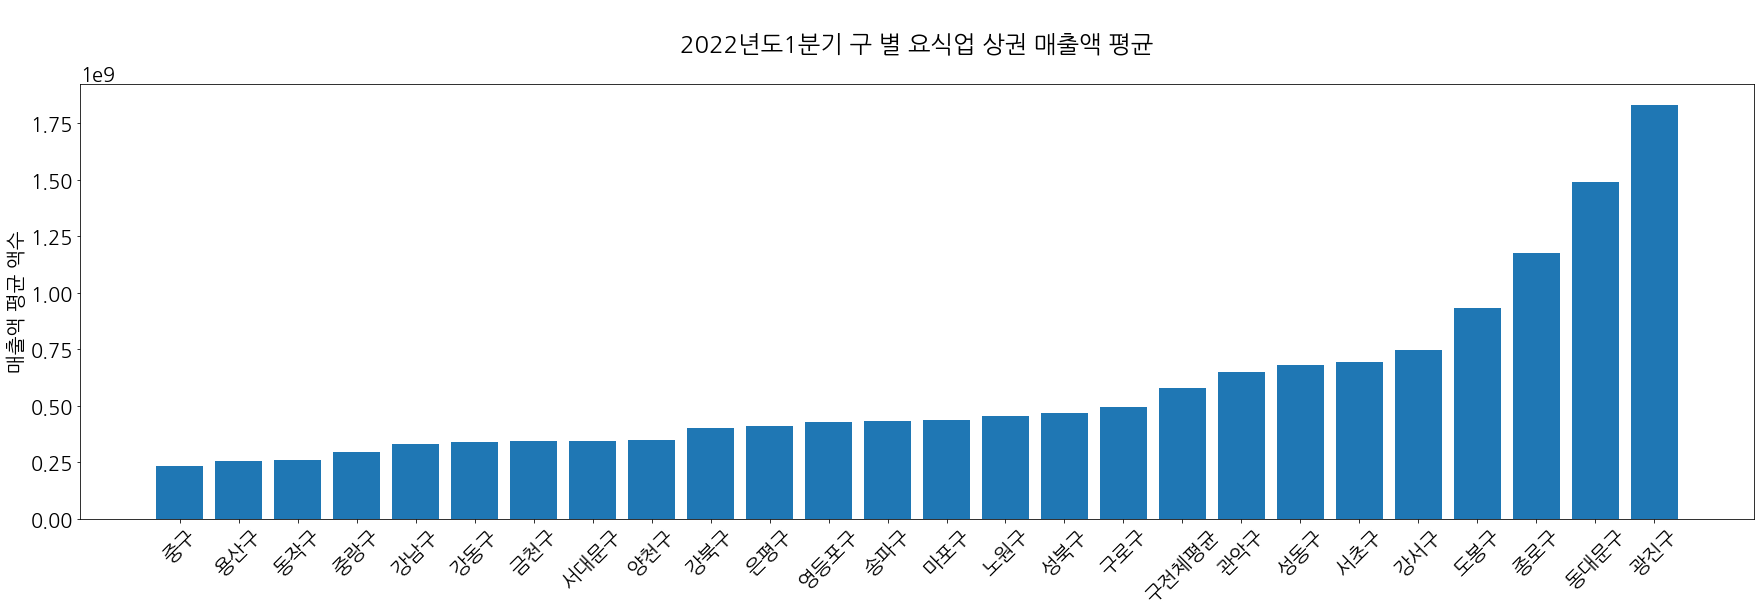

In [109]:
### 현재와 가장 가까운 시점(2022년 1분기)에서의 구 별 평균매출액 현황
# => 현재 어떤 구의 매출이 가장 저조한가?

# 막대그래프 그릴때 사용할 데이터프레임 mean_2022q1 생성

mean_2022q1  = pd.DataFrame()
mean_2022q1 ['시군구명'] = mean_gu.index
mean_2022q1 ['2022년1분기'] = mean_gu['2022년1분기'].values
mean_2022q1.sort_values(by='2022년1분기', ascending=True, inplace=True) # 낮은 순으로


# 가로 막대그래프 생성

fig, ax = plt.subplots()

x = np.arange(len(mean_2022q1))  # 가로축에 들어갈 값
values = mean_2022q1['2022년1분기'].to_list()   # 세로축에 들어갈 값

plt.bar(x, values)


plt.rc('font', family='NanumGothic') # 한글 글꼴 설정
matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지


plt.title('\n2022년도1분기 구 별 요식업 상권 매출액 평균\n') # 그래프 제목
plt.rc('font', size=20)  # 글자 크기
plt.xticks(x, mean_2022q1['시군구명'].values.tolist(), rotation=45)
plt.ylabel('매출액 평균 액수') # y축 제목
# plt.ylim(-40, 50) # y축 표기범위
# legend_list = ['군전체평균추세'] + [i for i in inc_gu_trand1.index.to_list()] # 범주 생성
# plt.legend(legend_list) # 범주 출력

plt.rcParams["figure.figsize"] = [30,8] # 그래프 전체 크기

plt.show()

# To do List
# 매출액 평균 액수 숫자 제대로 보이게 수정
# 강조할 곳 선정
# 그리드 그리기


In [110]:
### 위 결과를 지도시각화

# 서울을 군별로 나눈 지도 데이터
# 출처 : https://github.com/southkorea/seoul-maps/tree/master/juso/2015/json
seoul_geo = "/content/gdrive/MyDrive/datafile/seoul_municipalities_geo_simple_match.json"


gu_csv = pd.read_csv('/content/gdrive/MyDrive/datafile/시군구위도경도_new.csv')
gu_csv = gu_csv[['SIG_KOR_NM', 'x', 'y']]
mean_2022q1 = pd.merge(mean_2022q1, gu_csv, left_on='시군구명', right_on='SIG_KOR_NM')


from folium.features import DivIcon

m = folium.Map(location=[37.559819, 126.963895], zoom_start=10)
folium.Choropleth(geo_data=seoul_geo, 
                  data=mean_2022q1, 
                  columns=('시군구명', '2022년1분기'), 
                  key_on='feature.properties.SIG_KOR_NM',
                  fill_color='BuPu', 
                  fill_opacity=0.8,
                  line_opacity=0.5,
                  legend_name='2022년도1분기 구 별 요식업 상권 매출액 평균').add_to(m)

for i in mean_2022q1.index:
  folium.Marker( location=[mean_2022q1['y'][i], mean_2022q1['x'][i]],
      icon=folium.DivIcon(
          icon_size=(0,0),
          icon_anchor=(0,0),

          html='<div\
        style="\
          font-size: 1.5rem;\
          color: black;\
          background-color: rgba(255,255,255,0.7);\
          width:65px;\
          text-align:center;\
          margin:0px;\
        "><b>'
          +str(mean_2022q1['시군구명'][i])
          +"<br/><span style='color:blue; mergin: 0px;'>"
          + str(mean_2022q1['2022년1분기'][i])+'</span>'
          +'</b></div>',
      )).add_to(m)

m


2022년1분기 매출이 가장 저조한 지역은 중구, 가장 높은 지역은 광진구,
서울시 내에서도 지역간 매출 편차가 존재함을 알 수 있다.

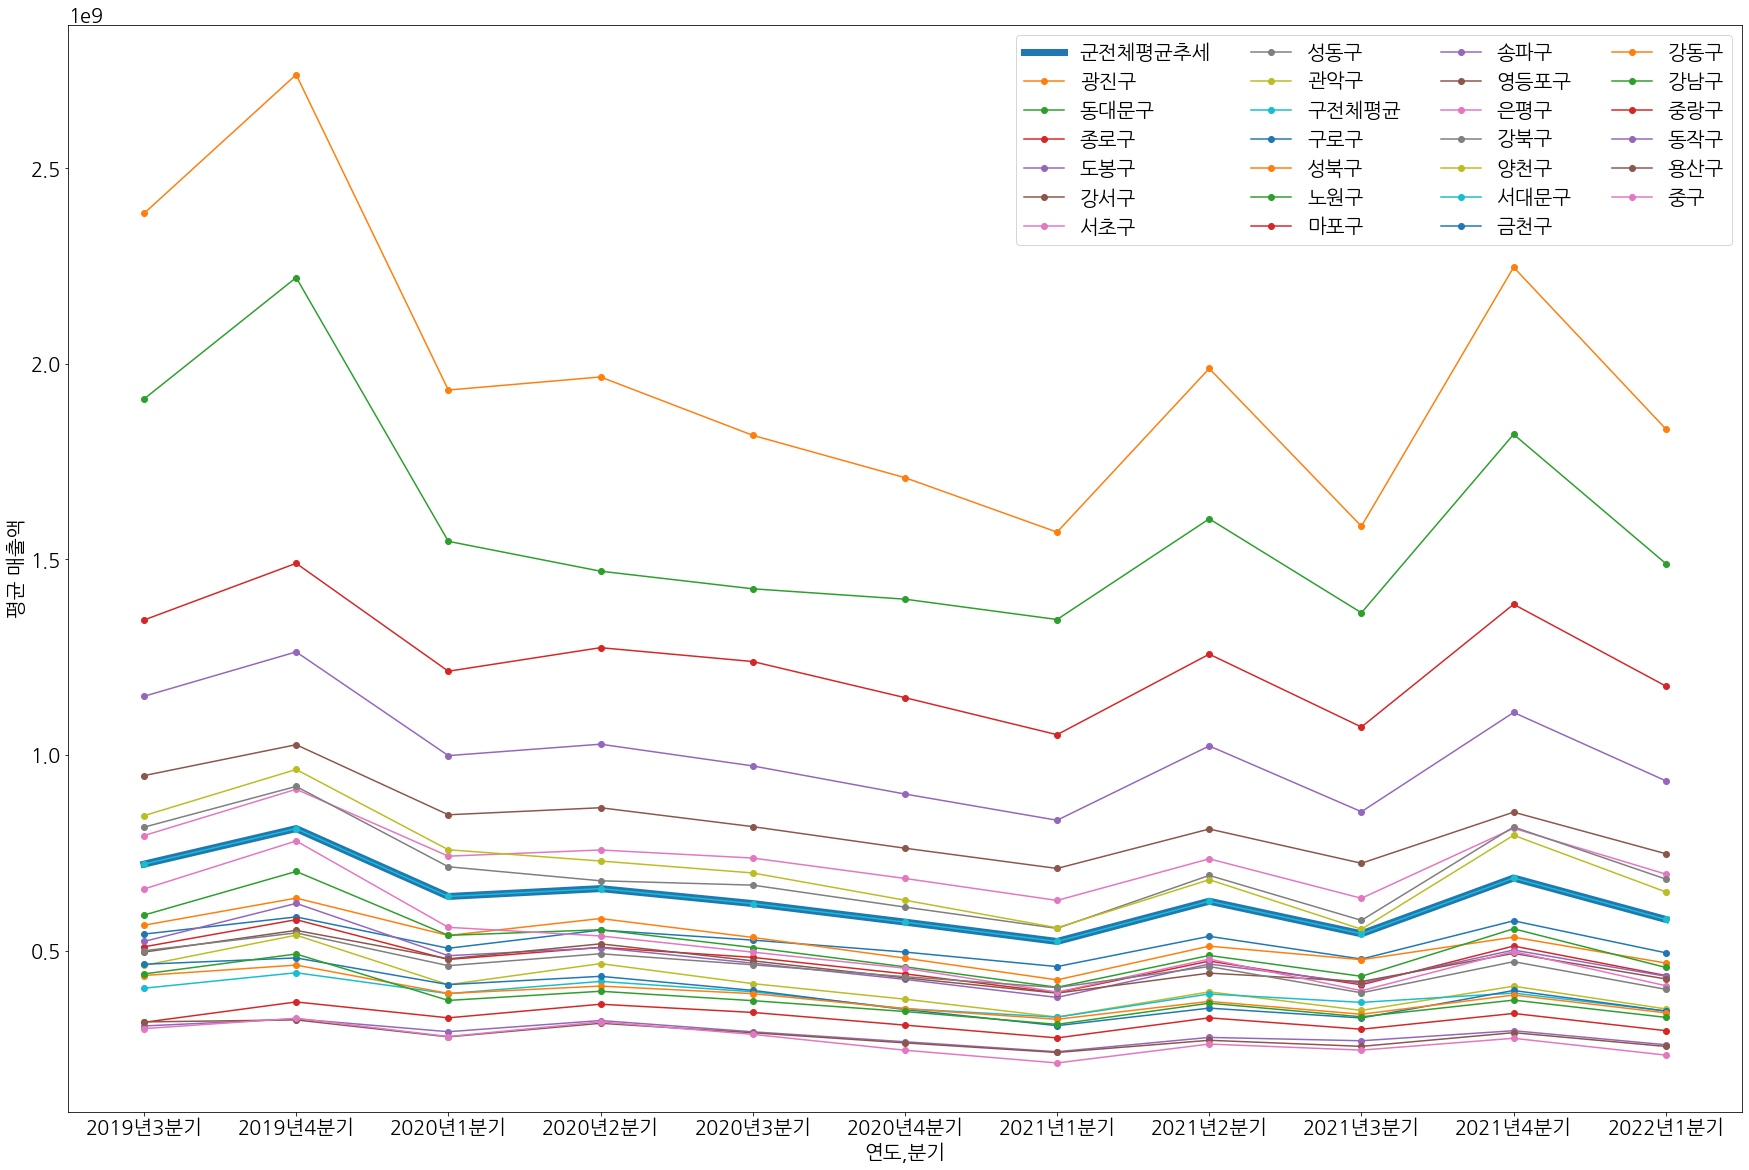

In [101]:
### 전체 현황 파악

# 꺾은선 그래프 그릴때 사용할 데이터프레임 mean_series 생성

mean_series = mean_gu.sort_values(by='2022년1분기', ascending=False)

x = np.arange(len(mean_series.columns))  # 가로축에 들어갈 값

plt.plot(x, mean_series.loc['구전체평균'], linewidth = '7.0') # 평균 추세, 선 두께 설정
for i in range(26) :
    plt.plot(x, mean_series.iloc[i], marker='o') # 2020년1분기 평균매출액 하위5개 구 선정
# for i in range(len(mean_series)-1,len(mean_series)-6, -1) :
#     plt.plot(x, mean_series.iloc[i], marker='o')

plt.rc('font', family='NanumGothic') # 한글 글꼴 설정
matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

plt.title('') # 그래프 제목
plt.xlabel('연도,분기') # x축 제목
plt.xticks(x, mean_series.columns.to_list(), rotation=0) # 실제로 x축에 표기할 내용
plt.ylabel('평균 매출액') # y축 제목

#plt.ylim(-40, 50) # y축 표기범위

legend_list = ['군전체평균추세'] \
              + [i for i in mean_series.index.to_list()]

plt.legend(legend_list, ncol=4) # 범주 출력
plt.rc('font', size=20)  # 글자 크기

plt.rcParams["figure.figsize"] = [30,20] 

plt.show()


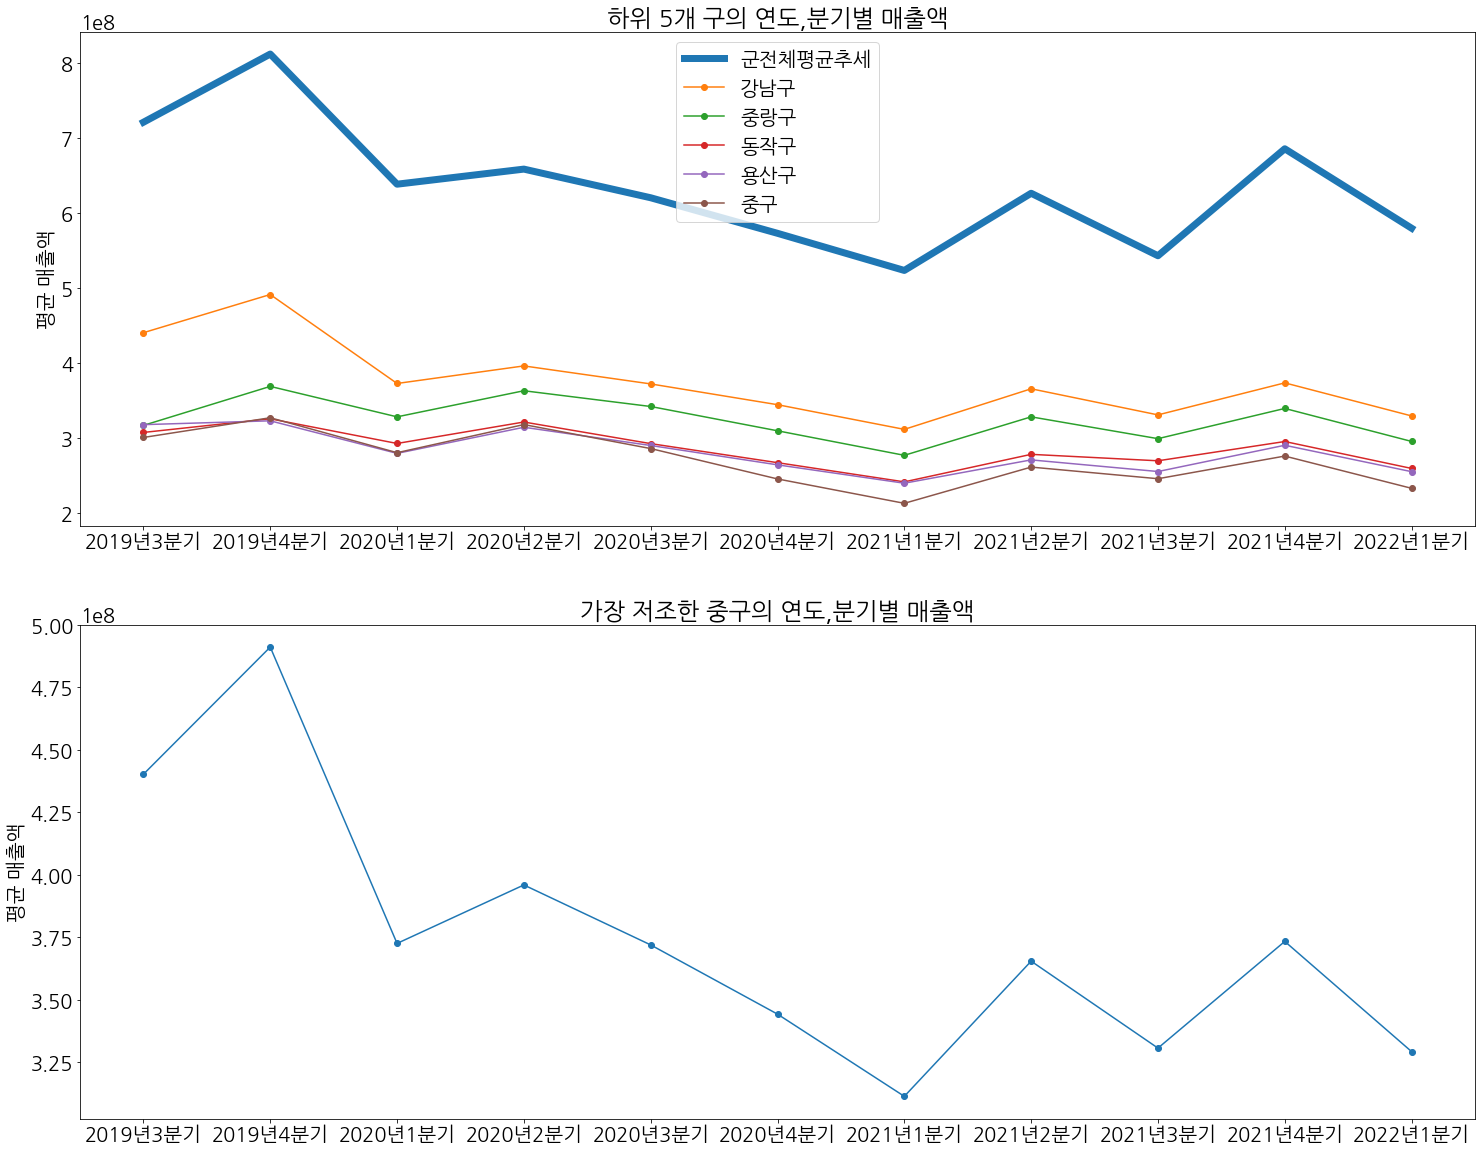

In [126]:
### 하위 5개 구 파악 & 가장 저조한 구 파악

# 꺾은선 그래프 그릴때 사용할 데이터프레임 mean_series_worst 생성

mean_series_worst = mean_gu.sort_values(by='2022년1분기', ascending=True)
mean_series_worst = mean_series_worst[:5]
mean_series_worst.sort_values(by='2022년1분기', ascending=False, inplace=True)

x = np.arange(len(mean_series_worst.columns))  # 가로축에 들어갈 값

plt.subplot(2, 1, 1)
plt.plot(x, mean_series.loc['구전체평균'], linewidth = '7.0') # 평균 추세, 선 두께 설정
for i in range(5) :
    plt.plot(x, mean_series_worst.iloc[i], marker='o') # 2020년1분기 평균매출액 하위5개 구 선정
plt.rc('font', family='NanumGothic') # 한글 글꼴 설정
plt.title('하위 5개 구의 연도,분기별 매출액') # 그래프 제목
plt.xticks(x, mean_series_worst .columns.to_list(), rotation=0) # 실제로 x축에 표기할 내용
plt.ylabel('평균 매출액') # y축 제목
legend_list = ['군전체평균추세'] \
              + [i for i in mean_series_worst .index.to_list()]
plt.legend(legend_list) # 범주 출력
plt.rc('font', size=20)  # 글자 크기

plt.subplot(2, 1, 2)
plt.plot(x, mean_series_worst .iloc[0], marker='o')
plt.rc('font', family='NanumGothic') # 한글 글꼴 설정
plt.title('가장 저조한 중구의 연도,분기별 매출액') # 그래프 제목
plt.xticks(x, mean_series_worst .columns.to_list(), rotation=0) # 실제로 x축에 표기할 내용
plt.ylabel('평균 매출액') # y축 제목
plt.rc('font', size=20)  # 글자 크기


plt.rcParams["figure.figsize"] = [25, 20] 

plt.show()
